# XGBOOST BASELINE for Semeval - Laptops 2014

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, classification_report

## Preprocessing

Function to add [CLS] and [SEP] as separator tokens at beginning/ending of each text item and to format aspect and polarity columns as lists:

In [0]:
def changeFormat(dataset):

  df = pd.DataFrame(dataset)
  text = df['text']
  aspect = df['aspect']
  polarity = df['polarity']
  df2 = pd.DataFrame({'text': '[CLS] ' + text + ' [SEP]',
                    'aspect': aspect,
                    'polarity': polarity})
  
  df2['polarity'] = [x.split(',') for x in df2['polarity']]
  df2['aspect'] = [x.split(',') for x in df2['aspect']]
  
  return df2

Read csv files from Google Drive (directly from shared group drive "NLP Lab"):

In [0]:
L14_train = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Train data/semevalLaptops_combi14_red_train.csv")

In [5]:
L14_train = changeFormat(L14_train)
L14_train.head()

,text,aspect,polarity
0,[CLS] The Apple applications (ex.iPhoto) are f...,[iPhoto],[positive]
1,[CLS] After replacing the hard drive the batte...,"[hard drive, battery, battery, hard drive]","[neutral, negative, negative, neutral]"
2,[CLS] † The screen almost looked like a barcod...,[screen],[negative]
3,[CLS] It is easy to navigate and update progra...,[navigate],[positive]
4,[CLS] My favorite part of this computer is tha...,[screen],[neutral]


In [0]:
L14_test = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Test data/semevalLaptops_combi14_red_test.csv")

In [7]:
L14_test = changeFormat(L14_test)
L14_test.head()

,text,aspect,polarity
0,[CLS] Now when I order I did not go full scale...,"[webcam, keyboard, carry]","[neutral, neutral, positive]"
1,[CLS] It had a cooling system malfunction afte...,"[use, cooling system]","[neutral, negative]"
2,[CLS] Your cursor will end up all over the fre...,[mousepad],[negative]
3,[CLS] I especially like the keyboard which has...,"[keys, keyboard]","[positive, positive]"
4,[CLS] Peformance is good for the price. [SEP],[price],[positive]


Shape of the train and test data:

In [8]:
L14_train.shape

(772, 3)

In [9]:
L14_test.shape

(194, 3)

##**BERT embeddings**

Preprocessing to import BERT embeddings file of group in Colab

In [10]:
!pip install pytorch-pretrained-bert

In [11]:
!pwd

/content


In [12]:
%cd "/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline"

/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline


In [0]:
from embeddings import Embeddings

In [0]:
embed = Embeddings()

Get BERT embeddings for train and test data:

In [0]:
L14_train_embeddings = embed.get_embeddings(L14_train.text, all=False)
L14_test_embeddings = embed.get_embeddings(L14_test.text, all=False)

Plausibility check

In [0]:
# number of vectors 
len(L14_train_embeddings[0])

28

In [0]:
#string is counted letter per letter
len(L14_train['text'][0])

110

In [0]:
# original text
L14_train['text'][0]

'[CLS] The Apple applications (ex.iPhoto) are fun, easy, and really cool to use (unlike the competition)! [SEP]'

In [0]:
# vectors
L14_train_embeddings[0]

tensor([[-0.0806, -0.3573,  0.1408,  ..., -0.1660,  0.6137,  0.5298],
        [-0.8065, -0.4155, -0.1265,  ...,  0.0949,  0.9043, -0.1873],
        [-0.2618,  0.4062,  0.1745,  ..., -0.2549,  0.0766, -0.4062],
        ...,
        [ 0.0155, -0.5340,  0.4263,  ..., -0.5062,  0.9261,  0.0547],
        [-0.3009, -0.5104,  0.2312,  ...,  0.8922,  0.2116, -0.0580],
        [-0.4103, -0.5281,  0.9149,  ...,  0.5654,  0.4082,  0.1083]])

In [0]:
len(L14_test_embeddings[0])

44

In [0]:
L14_test['text'][0]

'[CLS] Now when I order I did not go full scale for the webcam or full keyboard I wanted something for basics of being easy to carry when I use crutchs or wheelchair and with a backpack laptop bag. [SEP]'

In [0]:
L14_train['embeddings'] = [e[0].numpy() for e in L14_train_embeddings]
L14_test['embeddings'] = [e[0].numpy() for e in L14_test_embeddings]

##**XGBOOST Baseline Model for Aspect**

In [0]:
L14_aspect = MultiLabelBinarizer()
L14_aspect.fit(L14_train.aspect)
L14_aspect.classes_

array(['BIOS', 'Bluetooth', 'Customer Service', 'DVD burner', 'Features',
       'GarageBand', 'Garageband', 'HD', 'Keyboard', 'Keynote',
       'MS Office', 'Mac OS', 'OS', 'OS X', 'Pages', 'Photoshop', 'RAM',
       'Runs', 'Screen', 'Touchpad', 'USB ports', 'Vista', 'Windows',
       'Windows 7', 'Windows 7 Starter', 'Word', 'appearance',
       'applications', 'batteries', 'battery', 'battery life', 'boot up',
       'browser', 'built', 'buttons', 'carry', 'case', 'cd drive',
       'charge', 'charger', 'colors', 'components', 'cooling system',
       'cords', 'cost', 'customer support', 'delivery', 'design',
       'display', 'drive', 'drivers', 'edges', 'extended warranty',
       'external mouse', 'fan', 'feature', 'features', 'feel',
       'functions', 'games', 'gaming', 'graphics', 'graphics card',
       'hard drive', 'hard drives', 'hardware', 'hinge', 'iLife',
       'iMovie', 'iPhoto', 'iTunes', 'iWork', 'internet', 'iphoto',
       'keyboard', 'keys', 'loads', 'look', 'm

In [0]:
y_L14_train_aspect = L14_aspect.transform(L14_train.aspect)
y_L14_test_aspect = L14_aspect.transform(L14_test.aspect)
y_L14_train_aspect[3]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['budget'] will be ignored
  .format(sorted(unknown, key=str)))


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [0]:
L14_xgb_aspect = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', n_estimators=500 , max_depth=3,
                                               learning_rate=0.05, n_jobs=24, verbosity=1,
                                               min_child_weight=20, scale_pos_weight=6, base_score=0.2))
L14_xgb_aspect.fit(np.array(list(L14_train.embeddings)), y_L14_train_aspect)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.2, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=3,
                                            min_child_weight=20, missing=None,
                                            n_estimators=500, n_jobs=24,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=6,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
        

In [0]:
L14_aspect_report = classification_report(y_L14_test_aspect, L14_xgb_aspect.predict(np.array(list(L14_test.embeddings))),
                            target_names=L14_aspect.classes_, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Text(0.5, 1.0, 'Multi-label aspect classification performance')

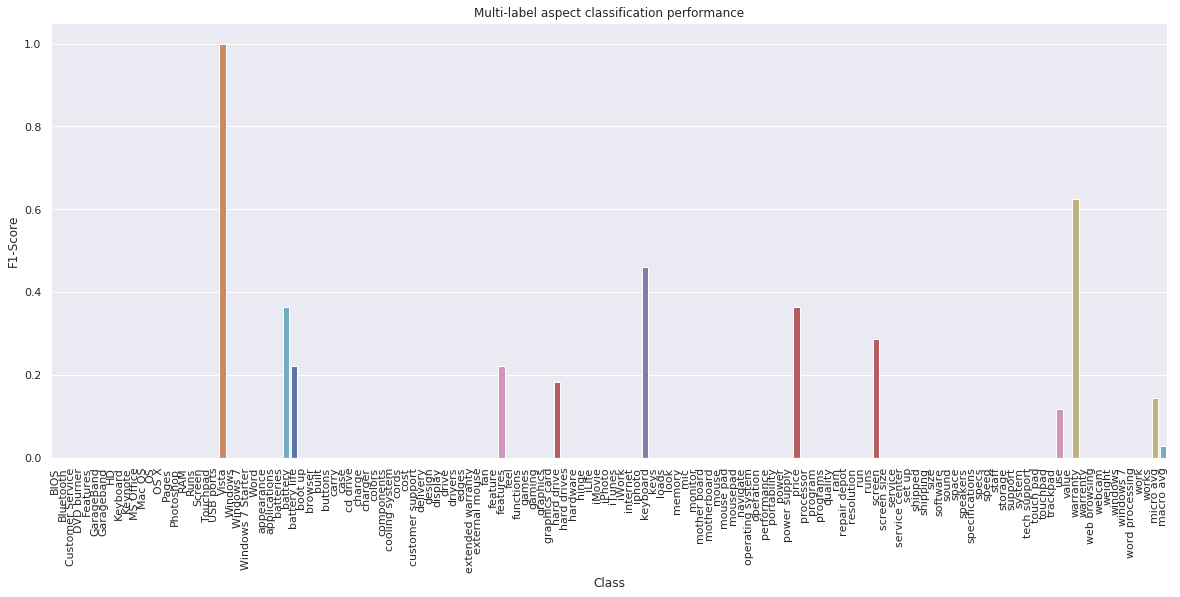

In [0]:
L14_f1s_aspect = []
for key in L14_aspect_report.keys():
    L14_f1s_aspect.append(L14_aspect_report.get(key).get('f1-score'))

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(list(L14_aspect_report.keys())[:-2], L14_f1s_aspect[:-2], palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Multi-label aspect classification performance')

In [0]:
[plt.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(L14_f1s_aspect[:-2])]

[Text(0.0, 0, '0.00'),
 Text(0.0, 1, '0.00'),
 Text(0.0, 2, '0.00'),
 Text(0.0, 3, '0.00'),
 Text(0.0, 4, '0.00'),
 Text(0.0, 5, '0.00'),
 Text(0.0, 6, '0.00'),
 Text(0.0, 7, '0.00'),
 Text(0.0, 8, '0.00'),
 Text(0.0, 9, '0.00'),
 Text(0.0, 10, '0.00'),
 Text(0.0, 11, '0.00'),
 Text(0.0, 12, '0.00'),
 Text(0.0, 13, '0.00'),
 Text(0.0, 14, '0.00'),
 Text(0.0, 15, '0.00'),
 Text(0.0, 16, '0.00'),
 Text(0.0, 17, '0.00'),
 Text(0.0, 18, '0.00'),
 Text(0.0, 19, '0.00'),
 Text(0.0, 20, '0.00'),
 Text(1.0, 21, '1.00'),
 Text(0.0, 22, '0.00'),
 Text(0.0, 23, '0.00'),
 Text(0.0, 24, '0.00'),
 Text(0.0, 25, '0.00'),
 Text(0.0, 26, '0.00'),
 Text(0.0, 27, '0.00'),
 Text(0.0, 28, '0.00'),
 Text(0.3636363636363636, 29, '0.36'),
 Text(0.2222222222222222, 30, '0.22'),
 Text(0.0, 31, '0.00'),
 Text(0.0, 32, '0.00'),
 Text(0.0, 33, '0.00'),
 Text(0.0, 34, '0.00'),
 Text(0.0, 35, '0.00'),
 Text(0.0, 36, '0.00'),
 Text(0.0, 37, '0.00'),
 Text(0.0, 38, '0.00'),
 Text(0.0, 39, '0.00'),
 Text(0.0, 40, '0.00

##**XGBOOST Baseline Model for Polarity**

In [0]:
L14_polarity = MultiLabelBinarizer()
L14_polarity.fit(L14_train.polarity)
L14_polarity.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [0]:
y_L14_train_polarity = L14_polarity.transform(L14_train.polarity)
y_L14_test_polarity = L14_polarity.transform(L14_test.polarity)
y_L14_train_polarity[3]

array([0, 0, 1])

In [0]:
L14_xgb_polarity = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', n_estimators=500 , max_depth=3,
                                                 learning_rate=0.05, n_jobs=24, verbosity=1, min_child_weight=50,
                                                 scale_pos_weight=6, base_score=0.3))
L14_xgb_polarity.fit(np.array(list(L14_train.embeddings)), y_L14_train_polarity)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.3, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=3,
                                            min_child_weight=50, missing=None,
                                            n_estimators=500, n_jobs=24,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=6,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
        

In [0]:
L14_polarity_report = classification_report(y_L14_test_polarity, L14_xgb_polarity.predict(np.array(list(L14_test.embeddings))),
                            target_names=L14_polarity.classes_, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Text(0.5, 1.0, 'Multi-label polarity classification performance')

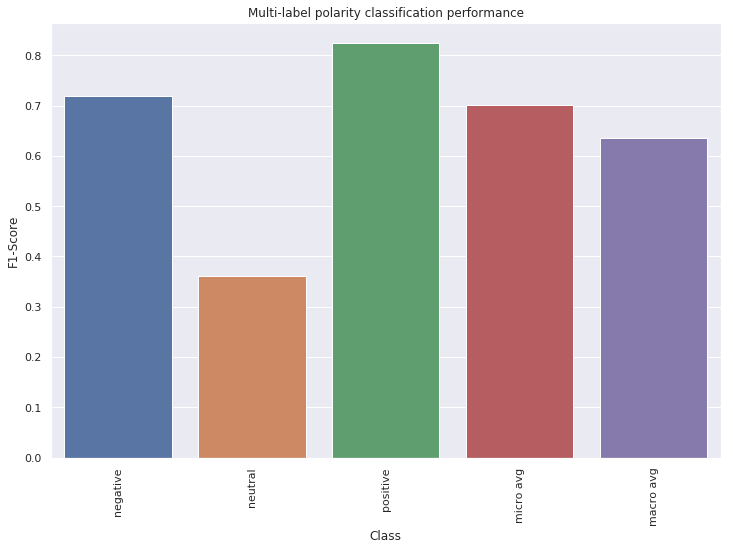

In [0]:
L14_f1s_polarity = []
for key in L14_polarity_report.keys():
    L14_f1s_polarity.append(L14_polarity_report.get(key).get('f1-score'))

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(list(L14_polarity_report.keys())[:-2], L14_f1s_polarity[:-2], palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Multi-label polarity classification performance')

[Text(0.7195767195767195, 0, '0.72'),
 Text(0.3614457831325301, 1, '0.36'),
 Text(0.8235294117647058, 2, '0.82'),
 Text(0.7016806722689075, 3, '0.70'),
 Text(0.6348506381579851, 4, '0.63')]

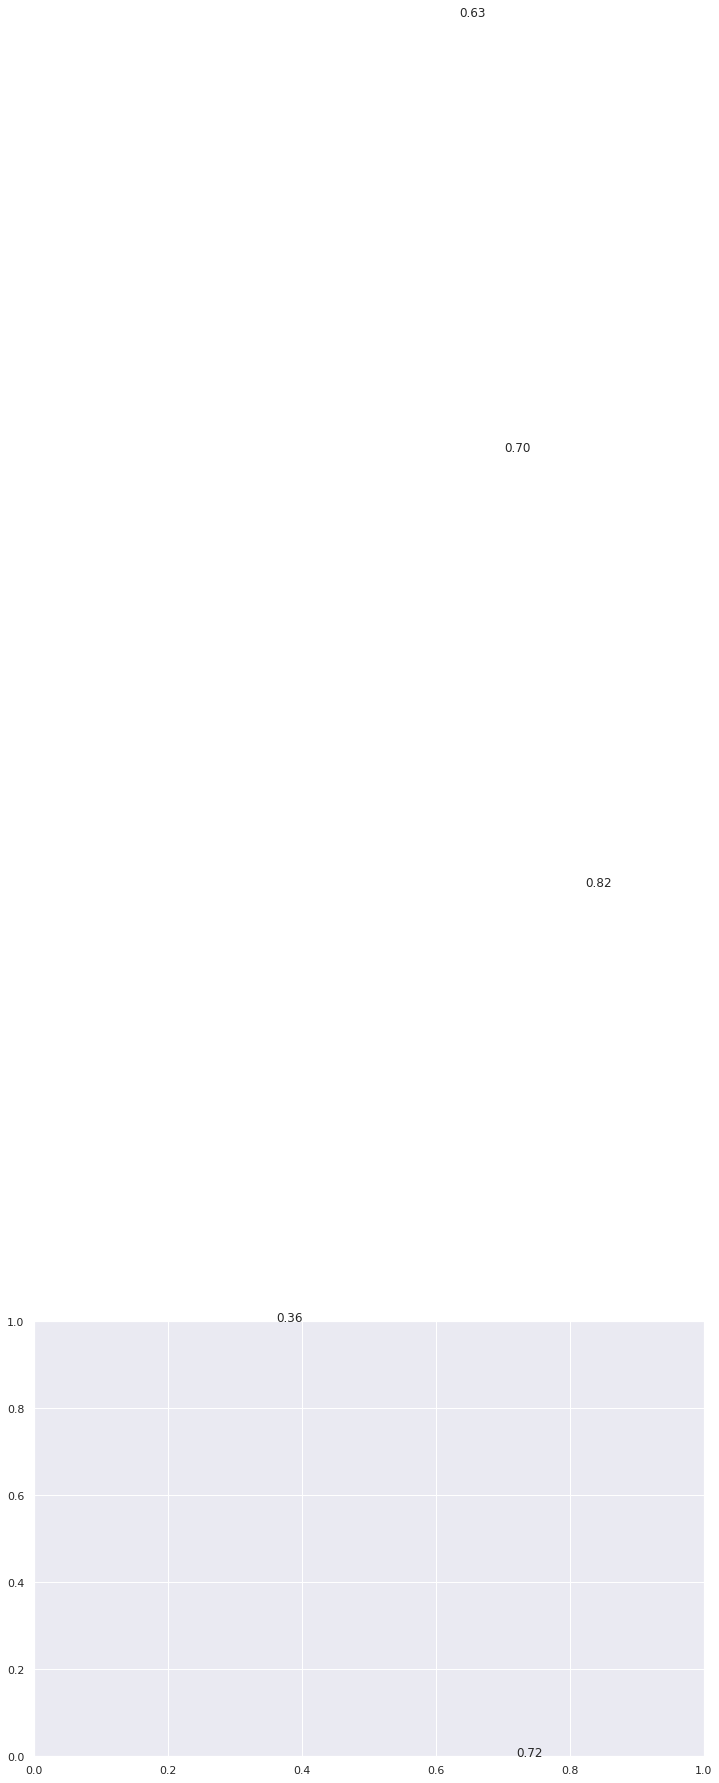

In [0]:
[plt.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(L14_f1s_polarity[:-2])]